## Physics-Informed Neural Network (PINN) for a 1D Sine Function

We want to learn the function  

$$
y(x) = \sin(x)
$$

**without training data**, using only a **differential equation** and **boundary conditions**.

---

### 1. Governing differential equation

The sine function is the solution of the second-order ordinary differential equation

$$
\boxed{y''(x) + y(x) = 0}
$$

This equation does **not** uniquely define the solution:  
any linear combination

$$
y(x) = A \sin(x) + B \cos(x)
$$

also satisfies the ODE.

---

### 2. Boundary conditions (BCs)

To select the unique sine solution, we impose:

$$
\boxed{
y(0) = 0, \qquad y'(0) = 1
}
$$

These conditions eliminate the cosine component and fix the amplitude:

$$
y(x) = \sin(x)
$$

---

### 3. Neural network ansatz

We approximate the solution with a neural network

$$
y_\theta(x) \approx y(x),
$$

where \( \theta \) are the trainable parameters.

The network takes \(x \in \mathbb{R}\) as input and outputs a scalar \(y_\theta(x)\).

---

### 4. Physics-informed loss function

The training loss consists of two parts.

#### (a) ODE residual loss (enforced everywhere)

Using automatic differentiation, we compute:

$$
y_\theta'(x), \quad y_\theta''(x)
$$

The ODE residual is

$$
r(x) = y_\theta''(x) + y_\theta(x)
$$

We minimize its mean-squared value over collocation points \(x_i\):

$$
\boxed{
\mathcal{L}_{\text{ODE}}
= \frac{1}{N} \sum_{i=1}^N \left( y_\theta''(x_i) + y_\theta(x_i) \right)^2
}
$$

---

#### (b) Boundary condition loss

At \(x = 0\), we enforce:

$$
\boxed{
\mathcal{L}_{\text{BC}}
= \left( y_\theta(0) - 0 \right)^2
+ \left( y_\theta'(0) - 1 \right)^2
}
$$

---

### 5. Total loss

The full PINN objective is

$$
\boxed{
\mathcal{L}
= \mathcal{L}_{\text{ODE}}
+ \lambda \, \mathcal{L}_{\text{BC}}
}
$$

with a weighting factor \( \lambda > 1 \) to strongly enforce the boundary conditions.

---

### 6. Training principle

- Collocation points are sampled in the domain \(x \in [0, 2\pi]\)
- No target values \(y(x)\) are used
- The network learns the solution by **minimizing physics violations**

---

### 7. Outcome

After training, the neural network satisfies:
- \(y_\theta''(x) + y_\theta(x) \approx 0\) for all \(x\)
- \(y_\theta(0) \approx 0\), \(y_\theta'(0) \approx 1\)

Thus, the PINN recovers:

$$
\boxed{y_\theta(x) \approx \sin(x)}
$$

This is a minimal, fully physics-driven 1D PINN example.


device: mps
ep    1 | total=1.478e+01 | ode=1.540e-01 | bc=1.463e+00
ep  400 | total=6.645e-02 | ode=6.618e-02 | bc=2.695e-05
ep  800 | total=7.783e-03 | ode=5.207e-03 | bc=2.576e-04
ep 1200 | total=2.005e-04 | ode=1.892e-04 | bc=1.121e-06
ep 1600 | total=1.478e-03 | ode=1.157e-04 | bc=1.362e-04
ep 2000 | total=5.962e-05 | ode=3.515e-05 | bc=2.447e-06
ep 2400 | total=2.082e-05 | ode=1.691e-05 | bc=3.910e-07
ep 2800 | total=3.374e-05 | ode=1.911e-05 | bc=1.463e-06
ep 3200 | total=2.380e-05 | ode=1.097e-05 | bc=1.283e-06
ep 3600 | total=2.303e-04 | ode=5.285e-05 | bc=1.775e-05
ep 4000 | total=1.276e-04 | ode=4.902e-05 | bc=7.854e-06


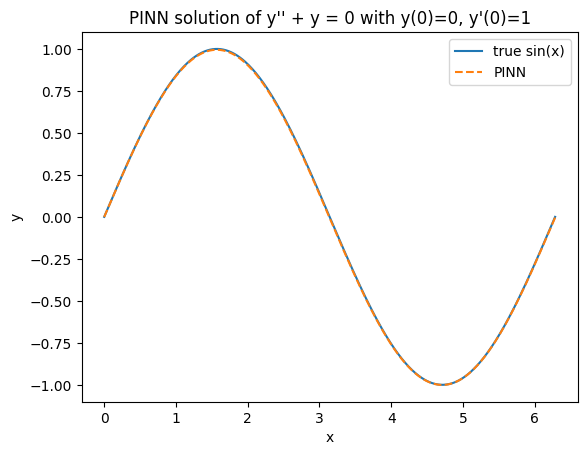

In [1]:
# PINN: learn y(x)=sin(x) from ODE y'' + y = 0 with BC y(0)=0, y'(0)=1
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math

torch.manual_seed(0)

# ------------------------------------------------------------
# Device selection (CUDA → MPS → CPU)
# ------------------------------------------------------------
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("device:", device)

# ------------------------------------------------------------
# 1) Simple MLP
# ------------------------------------------------------------
class MLP(nn.Module):
    def __init__(self, width=64, depth=4):
        super().__init__()
        layers = [nn.Linear(1, width), nn.Tanh()]
        for _ in range(depth - 1):
            layers += [nn.Linear(width, width), nn.Tanh()]
        layers += [nn.Linear(width, 1)]
        self.net = nn.Sequential(*layers)

        # Xavier init
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

model = MLP(width=64, depth=4).to(device)

# ------------------------------------------------------------
# 2) Autograd helpers: y', y''
# ------------------------------------------------------------
def derivatives(y, x):
    dy = torch.autograd.grad(
        y, x,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]

    d2y = torch.autograd.grad(
        dy, x,
        grad_outputs=torch.ones_like(dy),
        create_graph=True
    )[0]

    return dy, d2y

# ------------------------------------------------------------
# 3) Training domain and points
# ------------------------------------------------------------
x_min = 0.0
x_max = 2.0 * math.pi

N_col = 256

# Boundary point (x=0)
x0 = torch.tensor([[0.0]], device=device, requires_grad=True)

opt = torch.optim.Adam(model.parameters(), lr=2e-3)

w_ode = 1.0
w_bc  = 10.0

# ------------------------------------------------------------
# 4) Training loop
# ------------------------------------------------------------
def sample_collocation(n):
    x = x_min + (x_max - x_min) * torch.rand(n, 1, device=device)
    x.requires_grad_(True)
    return x

for ep in range(1, 4001):
    opt.zero_grad()

    # --- ODE residual
    x = sample_collocation(N_col)
    y = model(x)
    dy, d2y = derivatives(y, x)
    r = d2y + y
    loss_ode = torch.mean(r ** 2)

    # --- Boundary conditions
    y0 = model(x0)
    dy0, _ = derivatives(y0, x0)
    loss_bc = (y0 ** 2).mean() + ((dy0 - 1.0) ** 2).mean()

    loss = w_ode * loss_ode + w_bc * loss_bc
    loss.backward()
    opt.step()

    if ep % 400 == 0 or ep == 1:
        print(
            f"ep {ep:4d} | total={loss.item():.3e} "
            f"| ode={loss_ode.item():.3e} | bc={loss_bc.item():.3e}"
        )

# ------------------------------------------------------------
# 5) Evaluate + Plot
# ------------------------------------------------------------
model.eval()

xx = torch.linspace(x_min, x_max, 500, device=device).view(-1, 1)
with torch.no_grad():
    yy = model(xx)

xx_cpu = xx.cpu().numpy().reshape(-1)
yy_cpu = yy.cpu().numpy().reshape(-1)
true = torch.sin(xx).cpu().numpy().reshape(-1)

plt.figure()
plt.plot(xx_cpu, true, label="true sin(x)")
plt.plot(xx_cpu, yy_cpu, "--", label="PINN")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN solution of y'' + y = 0 with y(0)=0, y'(0)=1")
plt.savefig("pinn_sine_1.png")
plt.show()


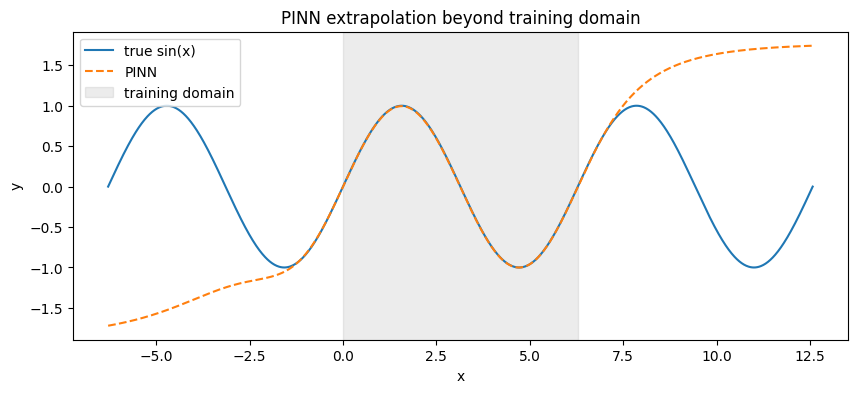

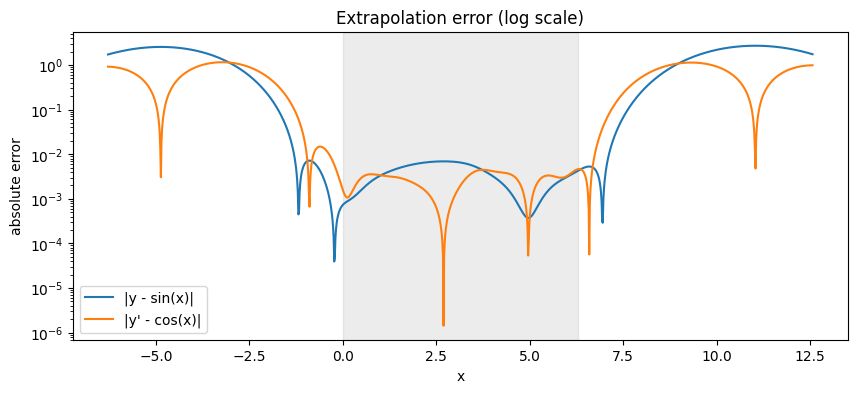

Mean abs error y(x):
  inside training domain : 3.613e-03
  outside training domain: 1.288e+00
Mean abs error y'(x):
  inside training domain : 2.639e-03
  outside training domain: 5.611e-01


In [2]:
# ------------------------------------------------------------
# 6) Evaluation beyond training domain
# ------------------------------------------------------------
model.eval()

# Extended domain: [-2π, 4π]
x_test_min = -2.0 * math.pi
x_test_max =  4.0 * math.pi

xx_ext = torch.linspace(x_test_min, x_test_max, 1200, device=device).view(-1, 1)
xx_ext.requires_grad_(True)

# PINN prediction
y_pred = model(xx_ext)

# True solution
y_true = torch.sin(xx_ext)

# First derivative
dy_pred, _ = derivatives(y_pred, xx_ext)
dy_true = torch.cos(xx_ext)

# Errors
err_y  = (y_pred - y_true).abs()
err_dy = (dy_pred - dy_true).abs()

# Move to CPU for plotting
xx_cpu   = xx_ext.detach().cpu().numpy().reshape(-1)
y_pred_c = y_pred.detach().cpu().numpy().reshape(-1)
y_true_c = y_true.detach().cpu().numpy().reshape(-1)
err_y_c  = err_y.detach().cpu().numpy().reshape(-1)
err_dy_c = err_dy.detach().cpu().numpy().reshape(-1)

# ------------------------------------------------------------
# Plots
# ------------------------------------------------------------
plt.figure(figsize=(10, 4))
plt.plot(xx_cpu, y_true_c, label="true sin(x)")
plt.plot(xx_cpu, y_pred_c, "--", label="PINN")
plt.axvspan(0, 2 * math.pi, color="gray", alpha=0.15, label="training domain")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN extrapolation beyond training domain")
plt.savefig("pinn_sine_2.png")
plt.show()

plt.figure(figsize=(10, 4))
plt.semilogy(xx_cpu, err_y_c + 1e-12, label="|y - sin(x)|")
plt.semilogy(xx_cpu, err_dy_c + 1e-12, label="|y' - cos(x)|")
plt.axvspan(0, 2 * math.pi, color="gray", alpha=0.15)
plt.legend()
plt.xlabel("x")
plt.ylabel("absolute error")
plt.title("Extrapolation error (log scale)")
plt.show()

# ------------------------------------------------------------
# Quantitative summary
# ------------------------------------------------------------
inside = (xx_cpu >= 0.0) & (xx_cpu <= 2.0 * math.pi)
outside = ~inside

print("Mean abs error y(x):")
print(f"  inside training domain : {err_y_c[inside].mean():.3e}")
print(f"  outside training domain: {err_y_c[outside].mean():.3e}")

print("Mean abs error y'(x):")
print(f"  inside training domain : {err_dy_c[inside].mean():.3e}")
print(f"  outside training domain: {err_dy_c[outside].mean():.3e}")


# To achieve better results outside of the core domain

## Collocation Sampling in Core and Extended Domains

In this PINN setup, we distinguish **three different domains**, each with a specific role.

---

### 1. Core domain (problem definition)

The original problem is defined on the interval

$$
\Omega_{\text{core}} = [0, 2\pi].
$$

This is the interval where:
- the solution is conceptually defined,
- plots and comparisons are typically shown,
- boundary conditions are imposed.

No training data $y(x)$ are used here.

---

### 2. Extended collocation domain (ODE enforcement)

To improve extrapolation, the **ODE residual is not enforced only on**
$\Omega_{\text{core}}$, but on a **larger domain**

$$
\Omega_{\text{col}} = [-2\pi, 4\pi].
$$

At each training iteration:
- $N$ collocation points $x_i$ are drawn **uniformly at random** from
  $\Omega_{\text{col}}$,
- the physics residual
  $$
  r(x_i) = y_\theta''(x_i) + y_\theta(x_i)
  $$
  is evaluated at these points,
- the mean-squared residual is minimized.

Formally:
$$
x_i \sim \mathcal{U}(\Omega_{\text{col}}).
$$

This enforces the differential equation **globally**, not only inside the core interval.

---

### 3. Boundary / anchor domain (uniqueness)

Boundary (anchor) conditions are imposed at a **single point**

$$
x = 0,
$$

with constraints
$$
y_\theta(0) = 0,
\qquad
y_\theta'(0) = 1.
$$

These conditions:
- select the unique sine solution from the null space of the ODE,
- are enforced independently of the collocation sampling.

---

### 4. Evaluation domain (generalization test)

After training, the solution is evaluated on an even larger interval

$$
\Omega_{\text{test}} = [-4\pi, 6\pi],
$$

which is **outside both**
$\Omega_{\text{core}}$ **and**
$\Omega_{\text{col}}$.

This domain is never seen during training and is used solely to assess:
- extrapolation stability,
- phase accuracy,
- long-range behavior of the learned solution.

---

### Summary

$$
\Omega_{\text{core}}
\;\subset\;
\Omega_{\text{col}}
\;\subset\;
\Omega_{\text{test}}.
$$

Only the **ODE residual** is sampled stochastically over space;  
boundary conditions are enforced at fixed locations.

This separation of domains makes it explicit **where physics is enforced**  
and **where generalization is tested**.


In [3]:
# ------------------------------------------------------------
# TRAINING: sample ODE residual outside [0, 2π]
# ------------------------------------------------------------
import torch
import torch.nn as nn
import math

torch.manual_seed(0)

# Device (CUDA → MPS → CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("device:", device)

# ------------------------------------------------------------
# Model
# ------------------------------------------------------------
class MLP(nn.Module):
    def __init__(self, width=64, depth=4):
        super().__init__()
        layers = [nn.Linear(1, width), nn.Tanh()]
        for _ in range(depth - 1):
            layers += [nn.Linear(width, width), nn.Tanh()]
        layers += [nn.Linear(width, 1)]
        self.net = nn.Sequential(*layers)

        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

model = MLP().to(device)

# ------------------------------------------------------------
# Autograd helpers
# ------------------------------------------------------------
def derivatives(y, x):
    dy = torch.autograd.grad(
        y, x,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]

    d2y = torch.autograd.grad(
        dy, x,
        grad_outputs=torch.ones_like(dy),
        create_graph=True
    )[0]

    return dy, d2y

# ------------------------------------------------------------
# Domains
# ------------------------------------------------------------
# Core interval (problem definition)
x_core_min, x_core_max = 0.0, 2.0 * math.pi

# Wider residual-sampling interval
x_col_min, x_col_max = -2.0 * math.pi, 4.0 * math.pi

N_col = 256

# Boundary point
x0 = torch.tensor([[0.0]], device=device, requires_grad=True)

# Optimizer
opt = torch.optim.Adam(model.parameters(), lr=2e-3)

w_ode = 1.0
w_bc  = 10.0

def sample_collocation(n):
    x = x_col_min + (x_col_max - x_col_min) * torch.rand(n, 1, device=device)
    x.requires_grad_(True)
    return x

# ------------------------------------------------------------
# Training loop
# ------------------------------------------------------------
for ep in range(1, 8001):
    opt.zero_grad()

    # ODE residual on extended domain
    x = sample_collocation(N_col)
    y = model(x)
    dy, d2y = derivatives(y, x)
    loss_ode = torch.mean((d2y + y) ** 2)

    # Anchor BCs at x=0
    y0 = model(x0)
    dy0, _ = derivatives(y0, x0)
    loss_bc = (y0 ** 2).mean() + ((dy0 - 1.0) ** 2).mean()

    loss = w_ode * loss_ode + w_bc * loss_bc
    loss.backward()
    opt.step()

    if ep % 400 == 0 or ep == 1:
        print(
            f"ep {ep:4d} | total={loss.item():.3e} "
            f"| ode={loss_ode.item():.3e} | bc={loss_bc.item():.3e}"
        )


device: mps
ep    1 | total=1.486e+01 | ode=2.268e-01 | bc=1.463e+00
ep  400 | total=4.129e-02 | ode=4.101e-02 | bc=2.847e-05
ep  800 | total=3.670e-02 | ode=3.563e-02 | bc=1.066e-04
ep 1200 | total=1.825e-02 | ode=1.791e-02 | bc=3.401e-05
ep 1600 | total=1.475e-02 | ode=1.230e-02 | bc=2.452e-04
ep 2000 | total=1.085e-02 | ode=1.074e-02 | bc=1.148e-05
ep 2400 | total=2.046e-02 | ode=1.066e-02 | bc=9.800e-04
ep 2800 | total=1.211e-02 | ode=9.135e-03 | bc=2.970e-04
ep 3200 | total=9.968e-03 | ode=8.689e-03 | bc=1.279e-04
ep 3600 | total=8.739e-03 | ode=7.060e-03 | bc=1.679e-04
ep 4000 | total=5.990e-03 | ode=5.340e-03 | bc=6.499e-05
ep 4400 | total=1.162e-02 | ode=2.515e-03 | bc=9.106e-04
ep 4800 | total=1.435e-03 | ode=9.737e-04 | bc=4.615e-05
ep 5200 | total=8.905e-04 | ode=3.419e-04 | bc=5.486e-05
ep 5600 | total=1.618e-04 | ode=1.512e-04 | bc=1.060e-06
ep 6000 | total=1.461e-03 | ode=1.796e-04 | bc=1.282e-04
ep 6400 | total=2.000e-04 | ode=8.470e-05 | bc=1.153e-05
ep 6800 | total=4.7

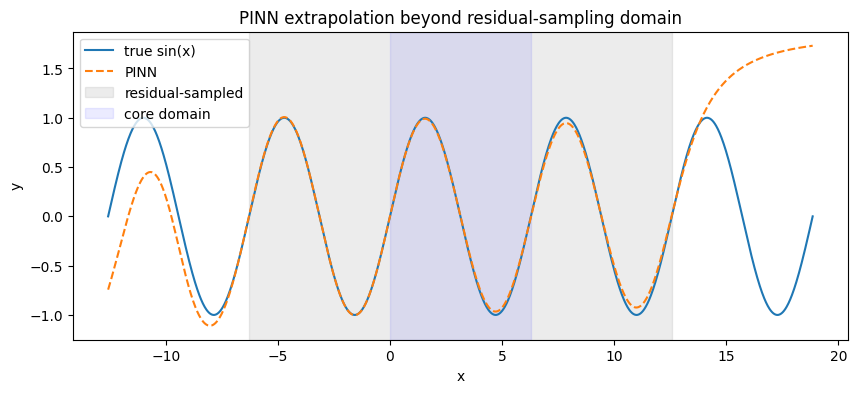

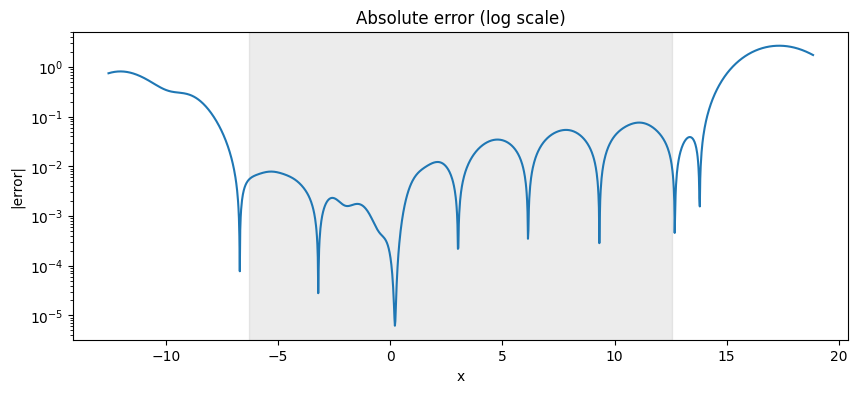

Mean absolute error:
  inside residual-sampled domain : 1.969e-02
  outside residual-sampled domain: 8.399e-01


In [4]:
# ------------------------------------------------------------
# EVALUATION: test beyond the residual-sampling domain
# ------------------------------------------------------------
import matplotlib.pyplot as plt

model.eval()

# Test domain larger than training-sampling domain
x_test_min = -4.0 * math.pi
x_test_max =  6.0 * math.pi

xx = torch.linspace(x_test_min, x_test_max, 1600, device=device).view(-1, 1)
xx.requires_grad_(True)

y_pred = model(xx)
y_true = torch.sin(xx)

# Errors
err = (y_pred - y_true).abs()

# Move to CPU
xx_cpu   = xx.detach().cpu().numpy().reshape(-1)
y_pred_c = y_pred.detach().cpu().numpy().reshape(-1)
y_true_c = y_true.detach().cpu().numpy().reshape(-1)
err_c    = err.detach().cpu().numpy().reshape(-1)

# ------------------------------------------------------------
# Plots
# ------------------------------------------------------------
plt.figure(figsize=(10, 4))
plt.plot(xx_cpu, y_true_c, label="true sin(x)")
plt.plot(xx_cpu, y_pred_c, "--", label="PINN")
plt.axvspan(-2*math.pi, 4*math.pi, color="gray", alpha=0.15, label="residual-sampled")
plt.axvspan(0, 2*math.pi, color="blue", alpha=0.08, label="core domain")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN extrapolation beyond residual-sampling domain")
plt.savefig("pinn_sine_3.png")
plt.show()

plt.figure(figsize=(10, 4))
plt.semilogy(xx_cpu, err_c + 1e-12)
plt.axvspan(-2*math.pi, 4*math.pi, color="gray", alpha=0.15)
plt.xlabel("x")
plt.ylabel("|error|")
plt.title("Absolute error (log scale)")
plt.show()

# ------------------------------------------------------------
# Quantitative summary
# ------------------------------------------------------------
inside = (xx_cpu >= x_col_min) & (xx_cpu <= x_col_max)
outside = ~inside

print("Mean absolute error:")
print(f"  inside residual-sampled domain : {err_c[inside].mean():.3e}")
print(f"  outside residual-sampled domain: {err_c[outside].mean():.3e}")


## Fourier Features — Classical View and Modern Terminology

In modern machine learning literature, *Fourier features* refer to a fixed
nonlinear **feature map** applied to the input before it is passed to a neural
network.  
Despite the name, this is **not** a Fourier transform in the classical signal-
processing sense.

---

### 1. Classical mathematical perspective

From a classical viewpoint, Fourier features correspond to expanding a function
in a **trigonometric basis**.

Given an input variable $x \in \mathbb{R}$, define the feature map

$$
\phi(x)
=
\bigl[
\sin(\omega_1 x), \cos(\omega_1 x),
\ldots,
\sin(\omega_m x), \cos(\omega_m x)
\bigr].
$$

This is a **basis expansion** using sine and cosine functions with prescribed
frequencies $\omega_k$.

If the subsequent model is linear, the resulting function has the form

$$
y(x)
=
\sum_{k=1}^m
\left(
a_k \sin(\omega_k x)
+
b_k \cos(\omega_k x)
\right),
$$

which is exactly a **truncated Fourier series**.

---

### 2. Relation to the classical Fourier transform

The classical Fourier transform:
- maps a function to its frequency spectrum,
- is invertible,
- computes coefficients from data.

Fourier features do **none** of this.

Instead:
- frequencies $\omega_k$ are chosen *a priori*,
- coefficients are learned by optimization,
- no spectral analysis or inversion is performed.

Thus, Fourier features are **not a transform**, but a **fixed feature map**.

---

### 3. Data-science terminology

In data-science language, Fourier features are:
- a **nonlinear input embedding**,
- a **feature transform**,
- a **basis expansion** aligned with periodic structure.

The neural network that follows learns a function
$$
f_\theta : \phi(x) \mapsto y,
$$
rather than learning directly from $x$.

This shifts complexity from the network into the representation.

---

### 4. Why this helps neural networks

Standard multilayer perceptrons are biased toward learning smooth, slowly
varying functions of $x$.

Periodic or oscillatory functions require:
- large depth,
- many parameters,
- or careful training.

Fourier features make oscillatory behavior *linear* in feature space, which
dramatically improves:
- approximation quality,
- extrapolation,
- training stability.

---

### 5. Connection to kernel methods

Fourier features are closely related to:
- random Fourier features,
- spectral kernel approximations,
- reproducing kernel Hilbert spaces.

In this sense, they embed classical harmonic analysis into modern neural
networks.

---

### 6. Important limitation

Fourier features improve **representation**, not **identification**.

They allow the network to represent many periodic functions equally well:
$$
A \sin(x) + B \cos(x), \quad
\sin(x + \varphi), \quad
\alpha \sin(2x),
$$
etc.

Physical constraints, boundary conditions, or data are still required to select
the *correct* solution.

---

### Summary

From a classical perspective, Fourier features are a **trigonometric basis
expansion**.  
From a modern machine-learning perspective, they are a **fixed nonlinear feature
embedding**.

They bridge harmonic analysis and neural networks by making periodic structure
explicit in the representation.


device: mps
ep    1 | total=4.782e+03 | ode=4.716e+03 | bc=6.650e+00
ep  400 | total=1.485e+00 | ode=1.356e+00 | bc=1.291e-02
ep  800 | total=9.642e-01 | ode=9.289e-01 | bc=3.530e-03
ep 1200 | total=1.291e+00 | ode=9.867e-01 | bc=3.045e-02
ep 1600 | total=5.590e-01 | ode=5.448e-01 | bc=1.429e-03
ep 2000 | total=1.251e+00 | ode=1.150e+00 | bc=1.006e-02
ep 2400 | total=6.963e-01 | ode=6.656e-01 | bc=3.066e-03
ep 2800 | total=4.378e-01 | ode=3.986e-01 | bc=3.924e-03
ep 3200 | total=7.211e-01 | ode=7.132e-01 | bc=7.918e-04
ep 3600 | total=6.288e-01 | ode=6.184e-01 | bc=1.042e-03
ep 4000 | total=6.044e-01 | ode=6.010e-01 | bc=3.413e-04
ep 4400 | total=6.365e-01 | ode=5.967e-01 | bc=3.981e-03
ep 4800 | total=3.249e-01 | ode=3.235e-01 | bc=1.381e-04
ep 5200 | total=5.943e-01 | ode=4.828e-01 | bc=1.115e-02
ep 5600 | total=2.697e-01 | ode=2.638e-01 | bc=5.937e-04
ep 6000 | total=1.910e-01 | ode=1.831e-01 | bc=7.856e-04
ep 6400 | total=2.755e-01 | ode=2.674e-01 | bc=8.094e-04
ep 6800 | total=1.8

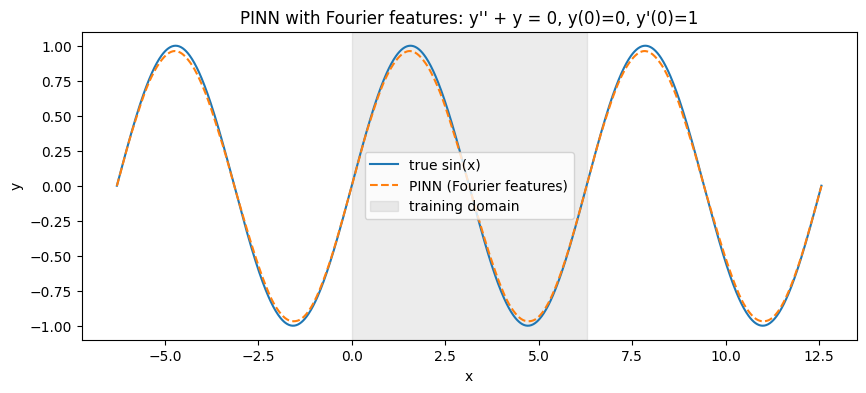

In [5]:
# ------------------------------------------------------------
# PINN with Fourier Features: learn y(x)=sin(x) from y''+y=0 and BC y(0)=0, y'(0)=1
# (Fourier features = input embedding; no sampling outside, no PBCs)
# ------------------------------------------------------------
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math

torch.manual_seed(0)

# Device (CUDA → MPS → CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("device:", device)

# ------------------------------------------------------------
# 1) Fourier feature embedding + small MLP
# ------------------------------------------------------------
class FourierMLP(nn.Module):
    def __init__(self, m=16, max_freq=16.0, width=64, depth=3):
        """
        m:        number of frequencies
        max_freq: largest frequency (in rad^-1 units); frequencies are linearly spaced
        width:    hidden width
        depth:    number of hidden layers AFTER the first (feature->width) layer
        """
        super().__init__()

        # Fixed frequencies ω_k (not trainable)
        omegas = torch.linspace(1.0, max_freq, m).view(1, m)  # shape (1,m)
        self.register_buffer("omegas", omegas)

        in_dim = 2 * m  # sin + cos

        layers = [nn.Linear(in_dim, width), nn.Tanh()]
        for _ in range(depth - 1):
            layers += [nn.Linear(width, width), nn.Tanh()]
        layers += [nn.Linear(width, 1)]
        self.net = nn.Sequential(*layers)

        # Xavier init
        for mod in self.net:
            if isinstance(mod, nn.Linear):
                nn.init.xavier_normal_(mod.weight)
                nn.init.zeros_(mod.bias)

    def features(self, x):
        # x: (N,1)
        # compute [sin(ωx), cos(ωx)] for ω_k
        z = x @ self.omegas  # (N,1)@(1,m) -> (N,m)
        return torch.cat([torch.sin(z), torch.cos(z)], dim=1)  # (N,2m)

    def forward(self, x):
        return self.net(self.features(x))

model = FourierMLP(m=16, max_freq=16.0, width=64, depth=3).to(device)

# ------------------------------------------------------------
# 2) Autograd helpers: y', y''
# ------------------------------------------------------------
def derivatives(y, x):
    dy = torch.autograd.grad(
        y, x, grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]
    d2y = torch.autograd.grad(
        dy, x, grad_outputs=torch.ones_like(dy),
        create_graph=True
    )[0]
    return dy, d2y

# ------------------------------------------------------------
# 3) Training domain: ONLY [0, 2π]
# ------------------------------------------------------------
x_min, x_max = 0.0, 2.0 * math.pi
N_col = 256

def sample_collocation(n):
    x = x_min + (x_max - x_min) * torch.rand(n, 1, device=device)
    x.requires_grad_(True)
    return x

x0 = torch.tensor([[0.0]], device=device, requires_grad=True)

opt = torch.optim.Adam(model.parameters(), lr=2e-3)
w_ode = 1.0
w_bc  = 10.0

# ------------------------------------------------------------
# 4) Training loop
# ------------------------------------------------------------
for ep in range(1, 12001):
    opt.zero_grad()

    # ODE residual on [0,2π]
    x = sample_collocation(N_col)
    y = model(x)
    dy, d2y = derivatives(y, x)
    r = d2y + y
    loss_ode = torch.mean(r**2)

    # Anchor BCs at x=0
    y0 = model(x0)
    dy0, _ = derivatives(y0, x0)
    loss_bc = (y0**2).mean() + ((dy0 - 1.0)**2).mean()

    loss = w_ode * loss_ode + w_bc * loss_bc
    loss.backward()
    opt.step()

    if ep % 400 == 0 or ep == 1:
        print(f"ep {ep:4d} | total={loss.item():.3e} | ode={loss_ode.item():.3e} | bc={loss_bc.item():.3e}")

# ------------------------------------------------------------
# 5) Evaluate + Plot (on a wider domain to see extrapolation)
# ------------------------------------------------------------
model.eval()
x_plot_min, x_plot_max = -2.0 * math.pi, 4.0 * math.pi

xx = torch.linspace(x_plot_min, x_plot_max, 1200, device=device).view(-1, 1)
with torch.no_grad():
    yy = model(xx)

xx_cpu = xx.cpu().numpy().reshape(-1)
yy_cpu = yy.cpu().numpy().reshape(-1)
true_cpu = torch.sin(xx).cpu().numpy().reshape(-1)

plt.figure(figsize=(10, 4))
plt.plot(xx_cpu, true_cpu, label="true sin(x)")
plt.plot(xx_cpu, yy_cpu, "--", label="PINN (Fourier features)")
plt.axvspan(0, 2*math.pi, color="gray", alpha=0.15, label="training domain")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN with Fourier features: y'' + y = 0, y(0)=0, y'(0)=1")
plt.savefig("pinn_sine_4.png")
plt.show()
